# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier

In this project, we are given a data set of $51,839$ samples of $32\cross32$ labeled RGB images of German traffic signs ([German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)). Our goal to build, train, and analyize an image classifier inspired by the LeNet Convolutional Nueral Network (CNN) architecture.  We will perform data exploration, where we try to find some useful preprocessing steps that allows us to extract more useful features for classification, artifcally generate additional image samples through image transformations, we will also build a tensorflow CNN model, tune the model hyperparameters, analyize the classifer operating characteristics, and finally examen the model filters that are generated from the training of the CNN.  Many parts of this notebook are inspired by Alex Staravoitau's work (https://navoshta.com/traffic-signs-classification/) and the work of Pierre Sermanet and Yann LeCun (http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

## Data Exploration and Augmentation

In [81]:
# required packages
import pickle
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
# importing the data sets
training_file = 'data/train.p'
validation_file='data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

class_labels = pd.read_csv('signnames.csv')

### Basic Summary of the Data

In [9]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples = ", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples =  4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Let's take a look at some of the examples in the training data set to get an idea of what we're working with.

In [67]:
# collecting images within the same classes
X_collections = []

for cls in range(n_classes):
    X_collections.append(X_train[y_train == cls])

Class Index: 32 - Class Label: End of all speed and passing limits - Class Training samples: 210


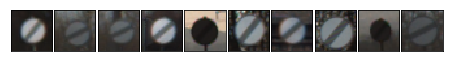

--------------------------------------------------------------------------------------

Class Index: 28 - Class Label: Children crossing - Class Training samples: 480


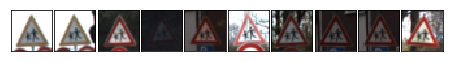

--------------------------------------------------------------------------------------

Class Index: 20 - Class Label: Dangerous curve to the right - Class Training samples: 300


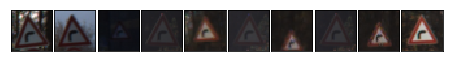

--------------------------------------------------------------------------------------

Class Index: 36 - Class Label: Go straight or right - Class Training samples: 330


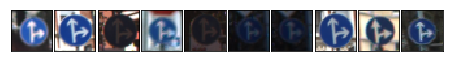

--------------------------------------------------------------------------------------

Class Index: 26 - Class Label: Traffic signals - Class Training samples: 540


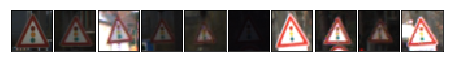

--------------------------------------------------------------------------------------



In [396]:
rand_class_sample = np.random.choice(range(len(X_collections)),5,replace=False)

for cidx in rand_class_sample :
    clab = class_labels.values[cidx,1]
    print("Class Index: %i - Class Label: %s - Class Training samples: %i" % (cidx,clab,len(X_collections[cidx])))
    fig = plt.figure(figsize = (6,1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    ridx = np.random.choice(range(len(X_collections[cidx])),10,replace=False)
    collection = X_collections[cidx][ridx]
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(collection[i])
    plt.show()
    print("--------------------------------------------------------------------------------------\n")

Let's take a look at the distribution of examples per class.

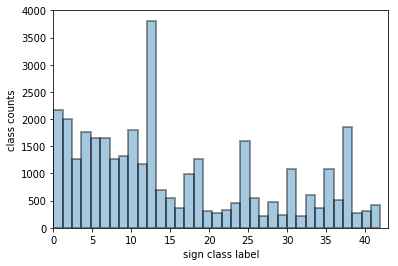

In [80]:
sns.distplot(y_train, kde=False, norm_hist=False, hist_kws=dict(edgecolor="k", linewidth=2))
plt.xlabel("sign class label")
plt.ylabel("class counts")
plt.xlim(0,43)
plt.show();

The un-even number of examples per class posses a challenge because if the classifier used none of the information within the image, and randomly sampled from this histogram its classification approximation, it would give a base accuracy of:

$P(\hat{y}=y) = \sum_\hat{y} \sum_y P(y)P(\hat{y})I(\hat{y}=y) =  \sum_y P(y)^2 = \sum_y \frac{N_y^2}{N^2} \approx 3.69\%$ 

versus when all classes have the same number of examples the base accuracy is 

$43 \frac{(N/43)^2}{N^2} = \frac{1}{43} \approx 2.32 \%$  so there is a slight bias in the dataset towards just guessing the more commonly occuring classes vs actually learning and determining something from the image data. We can correct for that by augmenting the dataset by artifcally generating new examples.

The dataset consists of images of traffic signs taken from various factors e.g. angles of incidence, brightness levels, backgrounds, image noise, sign orientation (rotation).  By transforming our training data set by applying rotations, persepective warps, noise addition, brightness changes, we can provide to the model more examples of what we're trying to classify, making it more likely we'll have similar images in the testing, and validation sets, and ultimately the real world to train against. Furthermore we can use this to even out the numbers of examples in each class such that we remove any inherent bias towards any one class.

In [363]:
# Augmenting the Dataset functions
def img_rotate(img,angle):
    tmp = np.copy(img)
    rows,cols,_ = tmp.shape

    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    dst = cv2.warpAffine(tmp,M,(cols,rows))
    
    # lots of geometery calcs were done to figure out how to
    # find the bounding box that doesn't have the black border
    # edges in a rotated image...
    # pt1: {cos(alpha)**2*sec(2*alpha)*(cols*cos(alpha)-rows*sin(alpha)), 
    #       0.5*(cols*cos(alpha)-rows*sin(alpha))*tan(2*alpha)}
    # pt2: {cos(alpha)**2*sec(2*alpha)*(cols*cos(alpha)-rows*sin(alpha)),
    #       sec(2*alpha)*(rows*cos(alpha)**3 - cols*sin(alpha)**3)}
    # pt3: {sec(2*alpha)*sin(alpha)**2(-cols*cos(alpha)+rows*sin(alpha)),
    #       sec(2*alpha)*(rows*cos(alpha)**3-cols*sin(alpha)**3)}
    alpha = angle*np.pi/180.
    #bottom right
    pt1 = {"x":np.cos(alpha)**2*(1./np.cos(2*alpha))*(cols*np.cos(alpha)-rows*np.sin(alpha)),
           "y":0.5*(cols*np.cos(alpha)-rows*np.sin(alpha))*np.tan(2*alpha)}
    # top right
    pt2 = {"x":np.cos(alpha)**2*(1./np.cos(2*alpha))*(cols*np.cos(alpha)-rows*np.sin(alpha)),
           "y":(1./np.cos(2*alpha))*(rows*np.cos(alpha)**3 - cols*np.sin(alpha)**3)}
    # top left
    pt3 = {"x":(1./np.cos(2*alpha))*np.sin(alpha)**2*(-cols*np.cos(alpha)+rows*np.sin(alpha)),
           "y":(1./np.cos(2*alpha))*(rows*np.cos(alpha)**3-cols*np.sin(alpha)**3)}
    
    # scaling the image to the new origin and size
    x_low = -rows*np.sin(alpha)
    x_high = rows*np.cos(alpha)
    #adjusting for the inverted y-axis in image data
    top_y = cols*np.sin(alpha)+rows*np.cos(alpha)
    
    By = rows
    Ay = -By/top_y

    Ax = cols/(x_high-x_low)
    Bx = -Ax*x_low
    
    # readjusting the to the new origin and scaling
    pt1["x"] = Ax*pt1["x"] + Bx
    pt2["x"] = Ax*pt2["x"] + Bx
    pt3["x"] = Ax*pt3["x"] + Bx
    
    pt1["y"] = Ay*pt1["y"] + By
    pt2["y"] = Ay*pt2["y"] + By
    pt3["y"] = Ay*pt3["y"] + By 
    
    lowcol = int(pt3["x"])
    hicol = int(pt1["x"])

    lowrow = int(pt2["y"])
    hirow = int(pt1["y"])
    
    croped = dst[lowrow:hirow,lowcol:hicol]
    
    # reshaped
    dst = cv2.resize(croped,(rows,cols))
    return dst

def img_brightness_adjust(img,a=1.0,b=0.0):
    tmp = np.copy(img)
    for ch in range(3):
        tmp[:,:,ch] = np.clip(a*tmp[:,:,ch] + b, 0, 255)

    return tmp

def img_3chEqualizer(img):
    tmp = np.copy(img)
    for ch in range(3):
        tmp[:,:,ch] = cv2.equalizeHist(tmp[:,:,ch])
    return tmp

def img_rand_perspective(img,scale=0.0):
    nrows,ncols,_ = img.shape
    deviation = np.int32(np.random.uniform(low=-scale,high=scale,size=3))
    
    lx = 0
    ly = 0
    hx = nrows
    hy = ncols
    
    # source coords
    src = np.float32([[lx,ly],[lx,hy],[hx,hy],[hx,ly]])
    # destination coordinates is perfect rectangle
    dst = np.float32([[lx,ly],
                      [lx,hy],
                      [hx,hy+deviation[1]],
                      [hx,ly+deviation[2]]])    
    
    # get the linear warp matrix
    M = cv2.getPerspectiveTransform(src,dst)
    # apply warp matrix
    warped = cv2.warpPerspective(img,M,(nrows,ncols),flags=cv2.INTER_LINEAR)
    
    lowy = int(max([dst[3,1],0]))
    hiy = int(min([32,dst[2,1]]))
    
    warped = warped[lowy:hiy,:]
    warped = cv2.resize(warped,(ncols,nrows))
    
    return warped

### Rotations 

Rotations allow different views of the signage, but also introduces some artifacts that we don't want the classifier to be able to use as a feature.  So after some trignomotery I have cropped rotated images so that the artifcats are not present in the images. An example of a rotation and crop is done below.

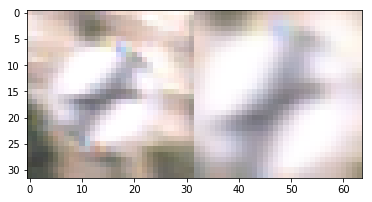

In [136]:
plt.imshow(np.hstack((X_train[41],img_rotate(X_train[41],15))));

### Brightness

Different times of the day, or lighting conditions can effect the exposure of each image, so by varying the brightness of an image, we're simulating different lighting conditions/times of the day for the images. An example is done below.

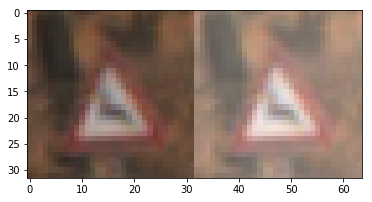

In [133]:
plt.imshow(np.hstack((X_train[300],img_brightness_adjust(X_train[300],a=1.0,b=60))));

### Equalization and Color spaces

Some of the images are quiet dark, and even for a human its hard to figure out what the sign is.  We can adjust the contrast in each image so that we spread out the differences between the dark and light pixels in a method known as histogram equalization. This will signficantly enhance the image contrast and allow those dark images to show more detail that makes it easier for a human to classify the images. An example is done below.

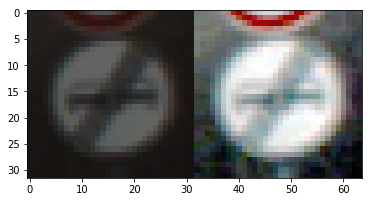

In [193]:
plt.imshow(np.hstack((X_train[20],img_3chEqualizer(X_train[20]))));

In [194]:
# Selecting especially dark examples
dark_img_idxs = np.mean(np.mean(np.mean(X_collections[12],axis=3),axis=1),axis=1)<20
dark_examples = X_collections[12][dark_img_idxs]

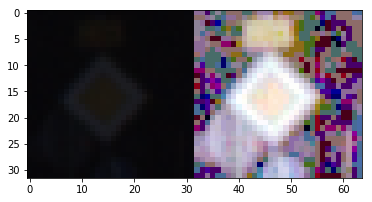

In [199]:
plt.imshow(np.hstack((dark_examples[0],img_3chEqualizer(dark_examples[0]))));

Unforuntely in this example we see a lot of noise in addition to the sign features we're looking for. It's not yet clear if our classifer will perform better on these examples where you can use the color information in the image, or changing to a different colorspace and using a particular channel may be a better feature for classification. An example of using the L channel in HLS space on the same image is shown below, and we will experiment with which feature set will be most useful.

In [200]:
hls = cv2.cvtColor(dark_examples[0],cv2.COLOR_RGB2HLS)

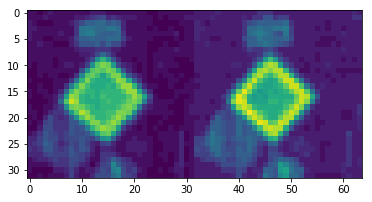

In [202]:
plt.imshow(np.hstack((dark_examples[0][:,:,1],hls[:,:,1])));

### Perspective Change

We also can add variety to our dataset by changing the persepective randomly in some of the images.  This allows our classifier to see more examples closer to real world examples that will likely be in the validation and test set, and therefore our classifier will generalize better. An example application is done below.

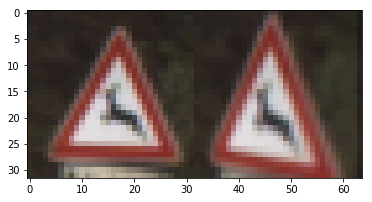

In [370]:
plt.imshow(np.hstack((X_train[500],img_rand_perspective(X_train[500],scale=10.0))));

There are also a class of rotations and reflections that could be generated to help give our classifier more examples to train against but I think these adjustments will allow good training without the reflects and rotations.

### Data Augmentation

So with these operations, we want to generate some fake data but taking into account we want to generate more images for those with lower number of examples, so that we have the same number of examples for each class of sign.

In [399]:
nsamples_class = 300
X_augmented = [[] for _ in range(len(X_collections))]

for cidx in range(len(X_collections)):
    ngenerate = nsamples_class-len(X_collections[cidx])
    if ngenerate <= 0:
        rand_idx = np.random.choice(range(len(X_collections[cidx])),nsamples_class,replace=False)
        X_augmented[cidx] = X_collections[cidx][rand_idx]
        for nidx in range(len(X_augmented[cidx])):
            X_augmented[cidx][nidx] = img_3chEqualizer(X_augmented[cidx][nidx])
            X_augmented[cidx][nidx] = cv2.cvtColor(X_augmented[cidx][nidx],cv2.COLOR_RGB2HLS)
            
    else:
        rand_idx = np.random.choice(range(len(X_collections[cidx])),ngenerate,replace=True)
        augset = X_collections[cidx][rand_idx]
        for nidx in range(len(augset)):
            rangle = np.random.uniform(low=-15.0,high=15)
            augset[nidx] = img_rotate(augset[nidx],rangle)
            
            rmag = np.random.uniform(low=-20,high=20)
            augset[nidx] = img_brightness_adjust(augset[nidx],a=1.0,b=rmag)
            
            augset[nidx] = img_rand_perspective(augset[nidx],scale=10.0)
            augset[nidx] = img_3chEqualizer(augset[nidx])
            augset[nidx] = cv2.cvtColor(augset[nidx],cv2.COLOR_RGB2HLS)
        
        X_augmented[cidx] = np.vstack((X_collections[cidx],augset))

Class Index: 28 - Class Label: Children crossing - Class Training samples: 300


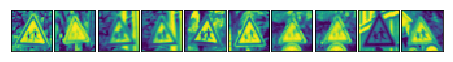

--------------------------------------------------------------------------------------

Class Index: 25 - Class Label: Road work - Class Training samples: 300


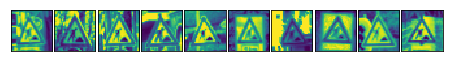

--------------------------------------------------------------------------------------

Class Index: 17 - Class Label: No entry - Class Training samples: 300


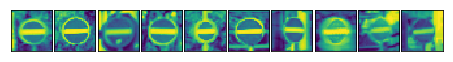

--------------------------------------------------------------------------------------

Class Index: 12 - Class Label: Priority road - Class Training samples: 300


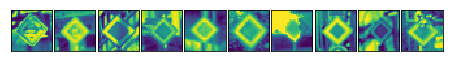

--------------------------------------------------------------------------------------

Class Index: 26 - Class Label: Traffic signals - Class Training samples: 300


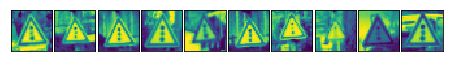

--------------------------------------------------------------------------------------



In [398]:
rand_class_sample = np.random.choice(range(len(X_augmented)),5,replace=False)

for cidx in rand_class_sample :
    clab = class_labels.values[cidx,1]
    print("Class Index: %i - Class Label: %s - Class Training samples: %i" % (cidx,clab,len(X_augmented[cidx])))
    fig = plt.figure(figsize = (6,1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    ridx = np.random.choice(range(len(X_augmented[cidx])),10,replace=False)
    collection = X_augmented[cidx][ridx]
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(collection[i][:,:,1])
    plt.show()
    print("--------------------------------------------------------------------------------------\n")

### Data Normalization

Because the images are single or multiple channel pixel values between 0-255 we can rescale the pixel values to between 0 and 1 so that the CNN works more efficently.

In [402]:
X_augmented = np.array(X_augmented)/255.

In [403]:
X_valid_aug = np.copy(X_valid)
for nidx in range(len(X_valid)):
    X_valid_aug[nidx] = img_3chEqualizer(X_valid_aug[nidx])
    X_valid_aug[nidx] = cv2.cvtColor(X_valid_aug[nidx],cv2.COLOR_RGB2HLS)/255. 

In [404]:
X_valid_aug = np.array(X_valid_aug)

## Constructing a Convolutional Nueral Network Classifier

The model we're going to build is going to based on the LeNet-5 archietecture where we have 2-3 convolutional layers of filter size (5x5) with "Valid" padding because the signs do not appear to be located near the edges, so we shouldn't need to worry about SAME or VALID padding as implemented in tensorflow. We'll have to tune the number of filters at each level but generally we'll expand to more and more filters as we get deeper into the network.  After 2-3 convolution layers we attach the output to 2 fully connected layers where the final output will be the logit values for each class.

We will have to experiment with using single channel information or multi-channel information as the input to the network, as well as adding dropout regularization to the fully connected layers to help the network generalize for the validation and test sets. 

One really interesting modification to the LeNet architecture is suggested in Alex Staravoitau's work where he implements and mutli-feature scale classifier by connecting the output of the shallow convolutional networks to both the following convolutional layer but also the 1st fully connected layer.  This allows the fc layer to work on both complex features built up from lower level features but also combinations of lower level features (lines, edges, etc) and complex features together to make a robust classifier.

### Model Architecture

In [405]:
from tensorflow.contrib.layers import flatten

In [451]:
tf.reset_default_graph()

def CNN_MultiScaleFeatures(x, nclasses, keep_prob=0.65, nchannels=3):    
    # Arguments used for tf.truncated_normal, 
    # randomly defines variables for the weights 
    # and biases for each layer
    mu = 0.0
    sigma = 0.1
        
    # Layer 1: Convolutional with n_layer1, 5x5 filters
    # Input = 32x32x3. Output = 28x28x(n_layer1).
    n_layer1 = 100
    w1 = tf.Variable(tf.truncated_normal(shape=(5,5,nchannels,n_layer1),mean=mu,stddev=sigma))
    b1 = tf.Variable(tf.zeros(n_layer1))
    
    conv1 = tf.nn.conv2d(x,w1,strides=[1,1,1,1],padding='VALID',name='convolution_1')+b1
    conv1 = tf.nn.relu(conv1)

    # Pooling Layer. max or avg we will try both
    # Input = 28x28x(n_layer1). Output = 14x14x(n_layer1).
    #pool1 = tf.nn.max_pool(conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    pool1 = tf.nn.avg_pool(conv1,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

    # Layer 2: Convolutional with n_layer2, 5x5 filters,
    # Input = 14x14x(n_layer1). Output = 10x10x(n_layer2).
    n_layer2 = 300
    w2 = tf.Variable(tf.truncated_normal(shape=(5,5,n_layer1,n_layer2),mean=mu,stddev=sigma))
    b2 = tf.Variable(tf.zeros(n_layer2))
    
    conv2 = tf.nn.conv2d(pool1,w2,strides=[1,1,1,1],padding='VALID',name='convolution_2')+b2
    conv2 = tf.nn.relu(conv2)

    # Pooling Layer. 
    # Input = 10x10x(n_layer2). Output = 5x5x(n_layer2).
    #pool2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    pool2 = tf.nn.avg_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    
    # Flatten conv layer1.
    # Input = 14x14x(n_layer1). Output = 14x14xn_layer1
    shape = pool1.get_shape().as_list()
    fc_pool1 = tf.reshape(pool1, [-1, shape[1] * shape[2] * shape[3]])
    flat1_size = shape[1] * shape[2] * shape[3]

    # Flatten conv layer2. 
    # Input = 5x5x(n_layer2). Output = 5x5xn_layer2.
    shape = pool2.get_shape().as_list()
    fc_pool2 = tf.reshape(pool2, [-1, shape[1] * shape[2] * shape[3]])  
    flat2_size = shape[1] * shape[2] * shape[3]
    
    flat = tf.concat([fc_pool1, fc_pool2],1)
    #flat = fc_pool2
    
    # Layer 3: Fully Connected. 
    # Input = flat1_size + flat2_size. Output = fc1_size.
    fc1_size = 200
    w3 = tf.Variable(tf.truncated_normal(shape=(flat1_size+flat2_size,fc1_size),mean=mu,stddev=sigma))
    b3 = tf.Variable(tf.zeros(fc1_size))
    
    fc = tf.matmul(flat,w3)+b3
    fc = tf.nn.relu(fc)
    fc = tf.nn.dropout(fc,keep_prob) # applying dropout to the FC layers
    
    
    # Layer 4: Fully Connected. 
    # Input = fc1_size. Output = fc2_size.
    fc2_size = 100
    w4 = tf.Variable(tf.truncated_normal(shape=(fc1_size,fc2_size),mean=mu,stddev=sigma))
    b4 = tf.Variable(tf.zeros(fc2_size))

    fc = tf.matmul(fc,w4)+b4
    fc = tf.nn.relu(fc)
    fc = tf.nn.dropout(fc,keep_prob)
    
    # Layer 5: Fully Connected. Input = fc_size2. Output = nclasses.
    w5 = tf.Variable(tf.truncated_normal(shape=(fc2_size,nclasses),mean=mu,stddev=sigma))
    b5 = tf.Variable(tf.zeros(nclasses))

    logits = tf.matmul(fc,w5)+b5

    return logits

In [452]:
n_ch = 3 # color channels of the data

# placeholder for the input shape of a batch of data
x = tf.placeholder(tf.float32, (None, 32, 32, n_ch))
# placeholder for the true class label
y = tf.placeholder(tf.int32, (None))

# function to map labels to one hot vectors
one_hot_y = tf.one_hot(y, n_classes)

# placeholder to specify the keep probablity
# for the dropout layers
keep_prob = tf.placeholder(tf.float32)

In [453]:
# initial learning rate for ADAM optimizer
lr = 0.001

# constructing the CNN on the tf graph
logits = CNN_MultiScaleFeatures(x, n_classes, keep_prob, n_ch)
# x-entropy loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss = tf.reduce_mean(cross_entropy)

# constructing the optimzation function
optimizer = tf.train.AdamOptimizer(learning_rate = lr)
training_operation = optimizer.minimize(loss)

In [456]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


saver = tf.train.Saver()

def mean_batch_accuracy(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [1]:
EPOCHS = 5
BATCH_SIZE = 128

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    num_examples = len(X_train_norm)
    #num_exampls = len(X_gray_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_norm[offset:end], y_processed[offset:end]
            #batch_x, batch_y = X_gray_train[offset:end], y_processed[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 0.6})
        
        train_accuracy = evaluate(X_train_norm, y_processed)
        validation_accuracy = evaluate(X_valid_norm, y_valid)
        #train_accuracy = evaluate(X_gray_train, y_processed)
        #validation_accuracy = evaluate(X_gray_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {:.3f}, Validation Accuracy = {:.3f}".format(train_accuracy,validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")